In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.constants import Planck, speed_of_light
from scipy.io import loadmat
import os
import re

Make sure that your data is in the correct format - you will need to have folders saved as 'currentmA_shorttime_longtime', with files inside labelled as: [short_in, long_in, short_out, long_out, bckg, long_bckg, empty, long_empty]. I will update this in future to generalise!

In [148]:
# This is all stuff for you to change!
################################################################################################

# add the paths to the data and the calibration file and power conversion csv (normally found on the X drive)
root_directory = r'C:\Users\php23st\Downloads\250129_IDPLQY_BA2PbI4\250129_IDPLQY\250129_RG0070_IDPLQY'
cal = np.loadtxt(r'G:\My Drive\Data\PLQY\2024-08-02_PLQYCalibrationfile2.txt')[:,1]
powers = pd.read_csv(r'G:\My Drive\Data\PLQY\csv_powers.csv', encoding='ISO-8859-1') # make sure this is a csv file, not xlsx

# these are the default settings, but you can toggle them at your peril
used_long_int = 1
laser_range = [395, 415]
pl_range = [560, 850]
stray_light=1

In [149]:
# analysis code to extract PLQY values from each set of measurements. This is pretty much the same as the normal PLQY code on the X Drive, 
# but I've refactored it so that we are working with dataframes rather than lists

def get_PLQY(data, short_time, long_time, cal, laser_range, pl_range, stray_light=False):
    """
    Processes the data and calculates PLQE, absorptance, etc.
    """
    # Extract data from dictionary
    short_in = data['short_in']
    short_out = data['short_out']
    long_in = data['long_in']
    long_out = data['long_out']
    short_bckg = data['bckg']
    short_empty = data['empty']
    long_bckg = data['long_bckg']
    long_empty = data['long_empty']
    
    wl = short_in['Wavelength']
    wl=wl.to_numpy()

    # Background subtraction
    def subtract(file, bckg):
        file['Intensity'] -= bckg['Intensity']
        return file

    subtract(short_in, short_bckg)
    subtract(short_out, short_bckg)
    subtract(short_empty, short_bckg)
    subtract(long_in, long_bckg)
    subtract(long_out, long_bckg)
    subtract(long_empty, long_bckg)

    # Scaling by integration time
    def scale(file, time):
        file['Intensity'] = file['Intensity'] / time
        return file

    scale(short_in, short_time)
    scale(short_out, short_time)
    scale(short_empty, short_time)
    scale(long_in, long_time)
    scale(long_out, long_time)
    scale(long_empty, long_time)

    # Combine short and long data
    def repl(short_, long_, wl, laser_range):
        low = np.max(np.argwhere(wl < laser_range[0]))
        high = np.min(np.argwhere(wl > laser_range[1]))
        combined = np.append(list(long_['Intensity'][0:low + 1]), list(short_['Intensity'][(low + 1):(high + 1)]))
        combined = np.append(combined, list(long_['Intensity'][(high + 1):]))
        return combined

    _in = repl(short_in, long_in, wl, laser_range)
    _out = repl(short_out, long_out, wl, laser_range)
    _empty = repl(short_empty, long_empty, wl, laser_range)

    # Apply calibration (generates spectra in µW/nm)
    _in *= cal
    _out *= cal
    _empty *= cal
    # put this back and put cal back into args for functions

    # Photon to energy conversion (J/photon)
    p2e = Planck * speed_of_light / (1e-9 * wl)

    # Integrals over given ranges
    def inte(d, x, _range):
        d_int = np.trapz(d[np.where((x > _range[0]) & (x < _range[1]))],
                         x=x[np.where((x > _range[0]) & (x < _range[1]))])
        return d_int

    def remove_stray(_in, _out, _empty, wl, wl_range, pl_range):
        def get_avg(x, wl, wl_range):
            idx = [np.argmin(abs(wl - wl_range[0])), np.argmin(abs(wl - wl_range[1]))]
            avg = np.trapz(x[idx[0]:idx[1]], wl[idx[0]:idx[1]])
            return avg

        avg_empty = get_avg(_empty, wl, wl_range)
        avg_out = get_avg(_out, wl, wl_range)
        avg_in = get_avg(_in, wl, wl_range)

        def corr_pl_range(d, x, _empty, avg_data, avg_empty, _range):
            d_pl_range = d[np.where((x > _range[0]) & (x < _range[1]))]
            _empty_pl_range = _empty[np.where((x > _range[0]) & (x < _range[1]))]
            d_corr = (d_pl_range * (avg_empty / avg_data) - _empty_pl_range) * (avg_data / avg_empty)
            d[np.where((x > _range[0]) & (x < _range[1]))] = d_corr
            return d

        _in = corr_pl_range(_in, wl, _empty, avg_in, avg_empty, pl_range)
        _out = corr_pl_range(_out, wl, _empty, avg_out, avg_empty, pl_range)
        _empty = corr_pl_range(_empty, wl, _empty, avg_empty, avg_empty, pl_range)

        return _in, _out, _empty

    if stray_light == True:
        wl_range = [370, 390]
        _in, _out, _empty = remove_stray(_in, _out, _empty, wl, wl_range, pl_range)

    # Calculate PLQE and absorptance
    absorbed_full = 1 - inte(_in / p2e, wl, laser_range) / inte(_out / p2e, wl, laser_range)
    PL_full = inte(_in / p2e, wl, pl_range) - inte(_empty / p2e, wl, pl_range) - (1 - absorbed_full) * (
                inte(_out / p2e, wl, pl_range) - inte(_empty / p2e, wl, pl_range))
    QE_full = PL_full / (inte(_empty / p2e, wl, laser_range) * absorbed_full)

    # Prepare results in a dictionary
    results = {'PLQY' : QE_full * 100, 'Absorptance' : absorbed_full * 100}


    return results

In [158]:
# this function takes your root directory and loops the analysis code through the folders for each power measurement, spitting out 
# a nice dictionary at the end with PLQY values (and absorptance, so you can plot this if you want too)

def process_folders(root_directory):

    data = {}
    
    # Loop through all folders in the root directory
    for folder_name in os.listdir(root_directory):
        folder_path = os.path.join(root_directory, folder_name)
        
        # Only process if it's a folder
        if os.path.isdir(folder_path):
            # Extract current, short time, and long time from folder name
            match = re.search(r'(\d+)mA_short(\d+)_long(\d+)', folder_name)
            if match != None:
                current = match.group(1)
                long_time = int(match.group(3))
                short_time = int(match.group(2))


                # Dictionary to hold file names and their content
                files = {}
                
                # Read each file in the folder and store their content
                for file_name in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file_name)
                    if os.path.isfile(file_path):
                        try:
                            test_data = pd.read_csv(file_path, sep='\t', header=12)
                            test_data = test_data.reset_index(drop = False)
                            test_data = test_data.rename(columns={'index' : 'Wavelength', '>>>>>Begin Spectral Data<<<<<' : 'Intensity'})
                            files[file_name.split('.')[0]] = test_data
                        except Exception as e:
                            print(f"Error reading {file_name}: {e}")
                            files[file_name.split('.')[0]] = pd.DataFrame()  # Empty dataframe in case of error
                        
                    else:
            # Default empty dataframe if the file is missing
                        data[file.split('.')[0]] = pd.DataFrame()
                        
            dict = get_PLQY(files, short_time, long_time, cal, laser_range, pl_range, stray_light=True)
            data[current] = [dict['PLQY'], dict['Absorptance']]



            # convert into dataframe
            results_df = pd.DataFrame()

            currents = [int(key) for key in data.keys()]
            results_df['Current (mA)'] = currents
            plqys = [list(data.values())[i][0] for i in range(0, len(list(data.keys())))]
            results_df['PLQY'] = plqys
            abss = [list(data.values())[i][1] for i in range(0, len(list(data.keys())))]
            results_df['Absorptance'] = abss

            
            ## converting to photon flux
            laser_p2e = Planck * speed_of_light / (405*1e-9)

            for current in results_df['Current (mA)']:

                indi = powers.loc[(powers == current).any(axis=1)].index[0]
                pwr = powers.iloc[indi].iloc[2]

                i = results_df.loc[(results_df == current).any(axis=1)].index[0]
                results_df.loc[i, 'Power (mW/cm2)'] = pwr
    

            results_df['Photon Flux (e18 photons/s)'] = results_df['Power (mW/cm2)'] / (laser_p2e*1e21)
    
    
    return results_df





In [161]:
# running the code!

results = process_folders(root_directory)

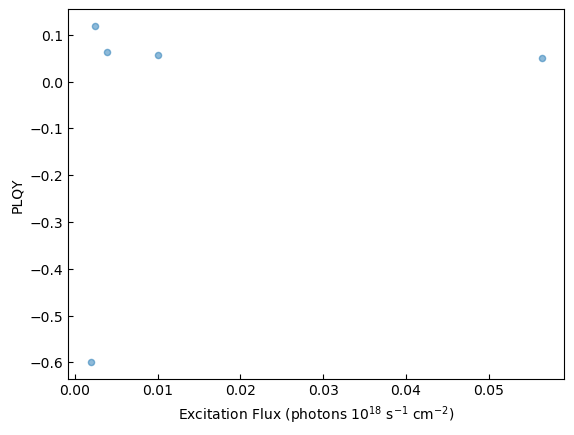

In [163]:
## plotting - mess around with this however much you like. The dataframe 'results' contains the PLQY, absorptance, current, laser power (mW/cm2)
# and photon flux, so plot whichever of these you like by changing 'x = ___' or 'y = ___' in the first line

ax = results.plot.scatter(x = 'Photon Flux (e18 photons/s)', y = 'PLQY', marker = 'o', alpha = 0.5)
# ax.set_ylim(-1,5)
ax.set_ylabel('PLQY')
ax.set_xlabel('Excitation Flux (photons $10^{18}$ s$^{-1}$ cm$^{-2}$)')
ax.tick_params(direction = 'in')

In [164]:
ax.savefig('fig')

AttributeError: 'Axes' object has no attribute 'savefig'